# Contour handling using `cv2_topology_handler`

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from lib.cv2_topology_handler import *
%matplotlib inline

## Generate dummy image

In [2]:
img = np.zeros((50, 160))
img[10:41, 10:131] = 1
w = 20
for i in range((100-20)//w):
    img[20-2*i:36, 20+i*w:15+(i+1)*w] = 0
cv2.circle(img,(110,25), 10, 0, -1)
img[28:31, 25:31] = 1  # this will be ignored
img[5:10,5:10] = 1
img[20:31, 140:150] = 1
img = img.astype(np.uint8)*255

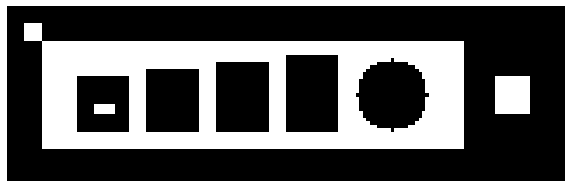

In [3]:
plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()

## Find contours

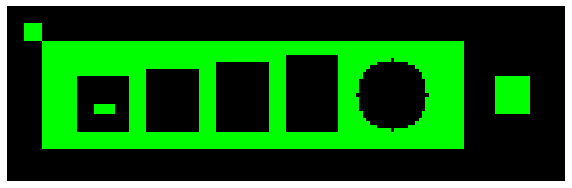

In [4]:
_, cont, hir = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rgb = cv2.cvtColor(img*255,cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb, cont, -1, (0,255,0), -1)
plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(rgb)
plt.show()

cv2 detects inner contours, however, they are encoded as separate entities.

For compatibility with COCO annotations, outer and inner contours (the excluded area)
need to be encoded as single entity. This handled with `handle_contour_topology  ()`.

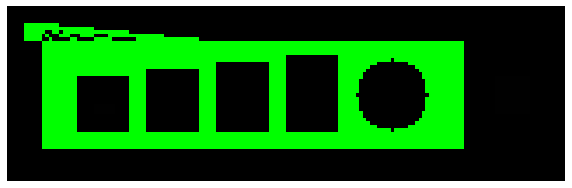

In [5]:
joint = handle_contour_topology(cont, hir, 1)
rgb = cv2.cvtColor(img*255,cv2.COLOR_GRAY2RGB)
cv2.drawContours(rgb, [joint], -1, (0,255,0), -1)  # note, that joint is now a single contour, not a list
plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(rgb)
plt.show()

Note, that 2nd level topology (white within black within white) is ignored.

the lines running between corners of inner and outer

## Convert to COCO format

See `coco_handler` module for docs and further utility functions.

In [6]:
from pycocotools.coco import COCO

def create_coco_segmentation(
    contours, entry_id, image_id, category_id, min_area=0, is_crowd=0
):
    """create coco segmentation from cv2 contours"""
    segs = []
    area = 0
    outline = []
    for c in contours:
        segs.append(c.ravel().tolist())
        area += cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)
        outline.append([x, y, x + w, y + h])
    if area < min_area:
        return None
    outline = np.array(outline)
    x = int(np.min(outline[:, 0]))
    y = int(np.min(outline[:, 1]))
    w = int(np.max(outline[:, 2])) - x
    h = int(np.max(outline[:, 3])) - y
    return {
        "id": entry_id,
        "image_id": image_id,
        "category_id": category_id,
        "iscrowd": is_crowd,
        "area": area,
        "bbox": [x, y, w, h],
        "segmentation": segs,
    }

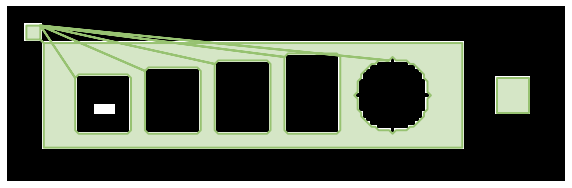

In [7]:
anns = [create_coco_segmentation(
    [joint, handle_contour_topology(cont, hir, 0)], 0, 0, 0)
    ]
coco = COCO()
plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(img, cmap="gray")
coco.showAnns(anns)
plt.show()

Note, that COCO defines the polygons differently, so the border pixels are not included
into the mask. We can compensate by morphological dilation.

In [8]:
img_d = cv2.dilate(img, kernel=np.ones((3,3)))
_, cont, hir = cv2.findContours(img_d, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
joint = handle_contour_topology  (cont, hir)

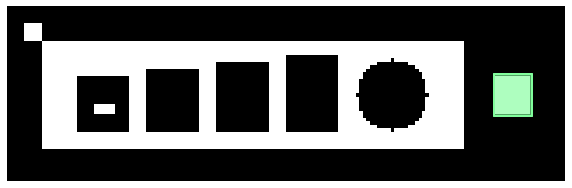

In [9]:
anns = [create_coco_segmentation(
    [joint, handle_contour_topology(cont, hir, 0)], 0, 0, 0)
    ]
coco = COCO()
plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(img, cmap="gray")
coco.showAnns(anns)
plt.show()

## Real world example

In [10]:
import imageio as io
mask = io.imread("../data/demo/contour_handling_demo_bug_mask.png")
img = io.imread("../data/demo/contour_handling_demo_bug.png")

In [11]:
# mask_d = cv2.dilate(mask, kernel=np.ones((3,3)))  # not required as some border background is in the mask
_, cont, hir = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
joint = handle_contour_topology  (cont, hir)

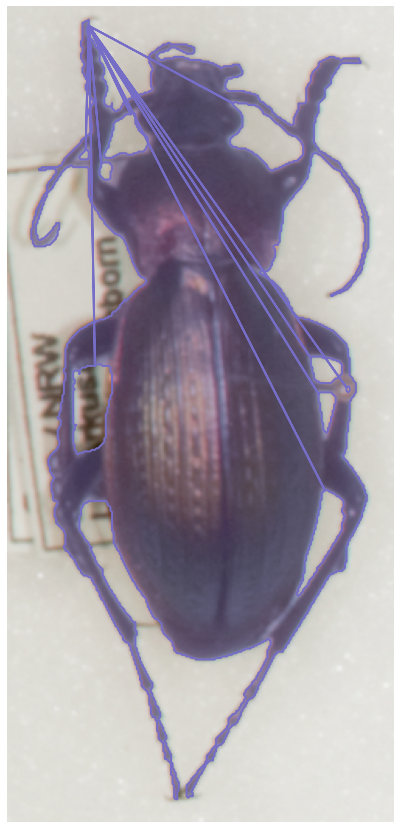

In [12]:
anns = [create_coco_segmentation([joint], 0, 0, 0)]
coco = COCO()
plt.figure(figsize=(10,15))
plt.axis("off")
plt.imshow(img)
coco.showAnns(anns)
plt.show()